In [1]:
import pickle
from Algorithms_curv import *
import pandas
import numpy as np
from open3d import *
read_point_cloud = io.read_point_cloud
read_triangle_mesh = io.read_triangle_mesh
write_point_cloud = io.write_point_cloud
registration_icp = registration.registration_icp
compute_fpfh_feature = registration.compute_fpfh_feature
TransformationEstimationPointToPlane = registration.TransformationEstimationPointToPlane
TransformationEstimationPointToPoint = registration.TransformationEstimationPointToPoint
Vector3dVector = utility.Vector3dVector
Vector3iVector = utility.Vector3iVector
draw_geometries = visualization.draw_geometries
write_triangle_mesh = io.write_triangle_mesh
paint_uniform_color = geometry.PointCloud.paint_uniform_color
voxel_down_sample = geometry.PointCloud.voxel_down_sample
estimate_normals = geometry.PointCloud.estimate_normals
KDTreeSearchParamHybrid = geometry.KDTreeSearchParamHybrid
PointCloud = geometry.PointCloud
TriangleMesh = geometry.TriangleMesh
sample_points_poisson_disk = geometry.TriangleMesh.sample_points_poisson_disk
create_sphere = geometry.TriangleMesh.create_sphere
sample_points_uniformly = geometry.TriangleMesh.sample_points_uniformly

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html
C:\Users\User\Anaconda2\envs\python3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# In[2]:

import time
time1=time.time()

In [3]:
# In[3]:


#load the 50 synthetic point clouds as training data
pcd_dens = [100000]

r1 = 1.5
r2 = 2

In [220]:
# In[4]:
whole = np.asarray(range(651,701))
#delete = np.asarray([61,67,69,84])
#delete = np.asarray([174])
delete = np.asarray([347])
rest = [x for x in whole if x not in delete]

newdata = []
for i in range(651,711):
#for i in range(901,961):    
#for i in rest:
    data = pandas.read_csv(r'preprocess_data/'+str(pcd_dens[0])+'/radius'+str(r1)+'-'+str(r2)+ '/data_curv_'+str(i)+'.csv')
    data_array = np.asarray(data)[:,1:]
    data_label = data_array[:,-1]
    data_def = []
    dist_array = data_array[:,3]
    dist_mean = np.mean(dist_array)
    dist_stdv = np.std(dist_array)
    defect_ind = []
    for l_ind in range(len(data_label)):
        label = data_label[l_ind]
        if label == 1:
            data_def.append(data_array[l_ind,:])
            defect_ind.append(l_ind)
            dist = data_array[l_ind,3]
            if abs(dist-dist_mean)<1.3*dist_stdv:
                data_array[l_ind,-1]=0
        
    newdata.append(data_array)


print("Time1:", time.time()-time1)
time2=time.time()

Time1: 661414.0245215893


In [88]:
trainindex = range(50)
testindex = range(50,60)

In [164]:
whole = np.asarray(testindex)
#delete = np.asarray([61,67,69,84])
#delete = np.asarray([174])
delete = np.asarray([50,52,53])
rest = [x for x in whole if x not in delete]

In [165]:
rest

[51, 54, 55, 56, 57, 58, 59]

In [221]:
model = BaggingClassifier()

#train the model with datasets from 1 to 40
#trainindex = random.sample(index,int(4*length/5))
for i in trainindex:
    patch1 = newdata[i]
    patch1 = np.asarray(patch1)
    #organize the training data
    #patch1 = patch1[:,1:]
    #print(patch1)
    np.random.shuffle(patch1)
    #n = int(0.8*len(patch1))
    x_train = patch1[:,(3,4,5,6,7)] #add second derovative in x axis of each point as input]
    y_train = patch1[:,-1]
    y_train_list = list(y_train)
    if y_train_list.count(1)>=6: #request for smote 
        sm = SMOTE()
        newx, newy = sm.fit_sample(x_train, y_train)
        model.fit(newx,newy)
    elif y_train_list.count(1) == 0:
        continue
    elif y_train_list.count(1) > 0 and y_train_list.count(1)<6:
        ros = RandomOverSampler()
        newx, newy= ros.fit_resample(x_train, y_train)
        model.fit(newx,newy)

In [171]:
cor = patch1[:,:3]
train_def = []
for i in range(len(y_train)):
    if y_train[i] == 1:
        train_def.append(patch1[i,:3])
pcd = PointCloud()
pcd.points = Vector3dVector(np.asarray(cor))
defpcd = PointCloud()
defpcd.points = Vector3dVector(np.asarray(train_def))

pcd.paint_uniform_color([0.8,0.8,0.8])
defpcd.paint_uniform_color([1,0,0])
draw_geometries([defpcd,pcd])

In [166]:
#get the F-measure and G-mean result of all the data from testindex
#F-measure result list
F_measure_list = []
    
#G-mean result list
G_mean_list = []


#for i in testindex:
for i in rest:
    test_def = []
    #manage test dataset
    test = newdata[i]
    test = np.asarray(test)
    #test = test[:,1:]
    X_test = test[:,(3,4,5,6,7)]
    y_test = test[:,-1]
    y_test = list(y_test)
    cor = test[:,:3]    
    #start test
    if y_test.count(1)<1:
        break
    else:
        #prediction result
        pred = model.predict(X_test)
            
        #define defect with label 1 as positive, the other class as negative
        TP = 0 #True Positive
        FP = 0 #False Positive
        TN = 0 #True Negative
        FN = 0 #False Negative
            
        for j in range(len(y_test)):
            if y_test[j] == 0 and y_test[j] == pred[j]:
                TN = TN + 1
            if y_test[j] == 1 and y_test[j] == pred[j]:
                TP = TP + 1    
            if y_test[j] == 0 and y_test[j] != pred[j]:
                FN = FN + 1  
            if y_test[j] == 1 and y_test[j] != pred[j]:
                FP = FP + 1
            if pred[j] == 1:
                test_def.append(cor[j])
        
        #calculate True Positive rate and True Negative rate
        if TP+FN==0:
            TP_rate = 0
        else:
            TP_rate = TP/(TP+FN) #True positive rate
        if TN+FP==0:
            TN_rate = 0
        else:
            TN_rate = TN/(TN+FP) #True negative rate
            
        #Positive predictive value
        PP_value = TP/(TP+FP) 
            
        #F-measure
        R = TP_rate
        P = PP_value
        if R == 0 or P == 0:
            F_measure = 0
        if R != 0 and P != 0:
            F_measure = 2/(1/R+1/P)
        #print(F_measure)
        F_measure_list.append(F_measure)
        #F-measure average
        F_ave = sum(F_measure_list)/len(F_measure_list)
        #F-measure std
        F_std = np.std(F_measure_list)
            
        #G-mean
        G_mean = math.sqrt(TP_rate*TN_rate)
        #print(G_mean)
        G_mean_list.append(G_mean)
        #G-mean average
        G_ave = sum(G_mean_list)/len(G_mean_list)
        #F-measure std
        G_std = np.std(G_mean_list)

    pcd = PointCloud()
    pcd.points = Vector3dVector(np.asarray(cor))
    defpcd = PointCloud()
    defpcd.points = Vector3dVector(np.asarray(test_def))

    pcd.paint_uniform_color([0.8,0.8,0.8])
    defpcd.paint_uniform_color([1,0,0])
    draw_geometries([pcd])

In [92]:
pred

array([1., 0., 1., ..., 0., 0., 0.])

In [93]:
test.shape

(59950, 11)

In [167]:
G_ave

0.9991103304324064

In [168]:
F_ave

0.8283853901548476

In [172]:
F_std

0.07079588335317774

In [173]:
G_std

0.0006615708043760896

In [169]:
test_def = []
i = testindex[1]
#manage test dataset
test = newdata[i]
test = np.asarray(test)
#test = test[:,1:]
X_test = test[:,(3,4,5,6,7)]
y_test = test[:,-1]
y_test = list(y_test)
cor = test[:,:3]    
    #start test


#prediction result
pred = model.predict(X_test)
            
#define defect with label 1 as positive, the other class as negative
TP = 0 #True Positive
FP = 0 #False Positive
TN = 0 #True Negative
FN = 0 #False Negative
            
for j in range(len(y_test)):
    if y_test[j] == 0 and y_test[j] == pred[j]:
        TN = TN + 1
    if y_test[j] == 1 and y_test[j] == pred[j]:
        TP = TP + 1    
    if y_test[j] == 0 and y_test[j] != pred[j]:
        FN = FN + 1  
    if y_test[j] == 1 and y_test[j] != pred[j]:
        FP = FP + 1
    if pred[j] == 1:
        test_def.append(cor[j])

In [170]:
pcd = PointCloud()
pcd.points = Vector3dVector(np.asarray(cor))
defpcd = PointCloud()
defpcd.points = Vector3dVector(np.asarray(test_def))

pcd.paint_uniform_color([0.8,0.8,0.8])
defpcd.paint_uniform_color([1,0,0])
draw_geometries([defpcd,pcd])

In [222]:
test_def = []

#manage test dataset
#test = pandas.read_csv(r'preprocess_data/'+str(pcd_dens[0])+'/radius'+str(r1)+'-'+str(r2)+ '/ex_curv_data1_patch_curradi_new.csv')
#test = pandas.read_csv(r'preprocess_data/'+str(pcd_dens[0])+'/radius'+str(r1)+'-'+str(r2)+ '/ex_curv_data1_new4.csv')
test = pandas.read_csv(r'ex_smooth_2_patch20_cur1.5.csv')
test = np.asarray(test)
test = test[:,1:]
X_test = test[:,(3,4,5,6,7)]
y_test = test[:,-1]
y_test = list(y_test)
cor = test[:,:3]    
    #start test


#prediction result
pred = model.predict(X_test)
            
#define defect with label 1 as positive, the other class as negative
TP = 0 #True Positive
FP = 0 #False Positive
TN = 0 #True Negative
FN = 0 #False Negative
            
for j in range(len(y_test)):
    if y_test[j] == 0 and y_test[j] == pred[j]:
        TN = TN + 1
    if y_test[j] == 1 and y_test[j] == pred[j]:
        TP = TP + 1    
    if y_test[j] == 0 and y_test[j] != pred[j]:
        FN = FN + 1  
    if y_test[j] == 1 and y_test[j] != pred[j]:
        FP = FP + 1
    if pred[j] == 1:
        test_def.append(cor[j])

In [223]:
#plot the defect points distance
dist_1 = []
for l in range(len(pred)):
    if pred[l] == 1: # and abs(X_test[1,0]) >1:
        dist_1.append(X_test[l,0])

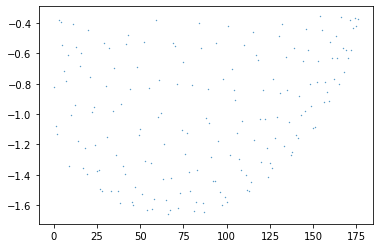

In [224]:
import matplotlib.pyplot as plt
plt.scatter(range(len(dist_1)),dist_1,s=0.125)
plt.show()

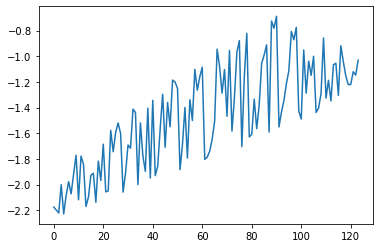

In [103]:
#plot the curvature of the defective points 
dist_1 = []
for l in range(len(y_test)):
    if y_test[l] == 1:
        dist_1.append(X_test[l,0])
plt.plot(dist_1)
plt.show()

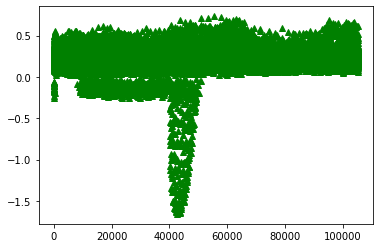

In [190]:
#plot distance according to labels
dist_1 = []
dist_0 = []
for l in range(len(y_test)):
    if y_test[l] == 1:
        dist_1.append(X_test[l,4])
    if y_test[l] == 0:
        dist_0.append(X_test[l,4])
distance = X_test[:,0]
label = y_test
plt.plot(distance,'g^')

plt.show()

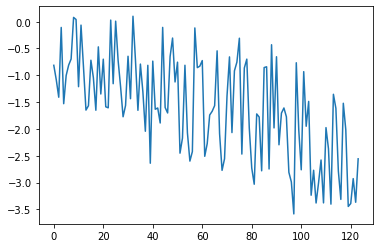

In [60]:
plt.plot(dist_1)

plt.show()

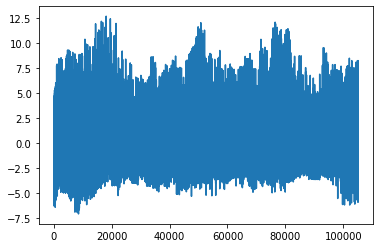

In [191]:
plt.plot(dist_0)

plt.show()

In [216]:
#calculate True Positive rate and True Negative rate
if TP+FN==0:
    TP_rate = 0
else:
    TP_rate = TP/(TP+FN) #True positive rate
if TN+FP==0:
    TN_rate = 0
else:
    TN_rate = TN/(TN+FP) #True negative rate
            
#Positive predictive value
PP_value = TP/(TP+FP) 
            
#F-measure
R = TP_rate
P = PP_value
if R == 0 or P == 0:
    F_measure = 0
if R != 0 and P != 0:
    F_measure = 2/(1/R+1/P)

In [217]:
F_measure

0.8057553956834532

In [219]:
pcd = PointCloud()
pcd.points = Vector3dVector(np.asarray(cor))
defpcd = PointCloud()
defpcd.points = Vector3dVector(np.asarray(test_def))

pcd.paint_uniform_color([0.8,0.8,0.8])
defpcd.paint_uniform_color([1,0,0])
draw_geometries([defpcd,pcd])

In [107]:
len(test_def)

231